## Cytokine Integration

In [1]:
import os.path as osp
import pandas as pd
import numpy as np
import string
import re
from tcre import meta
from tcre import lib
from tcre.meta import ID_TYP_CK, MIN_CK_SYM_LEN
from tcre.lib import CYTOKINES, SPECIES_HUMAN_ID, SPECIES_MOUSE_ID
from tcre.env import *
%matplotlib inline

In [2]:
greeks = pd.DataFrame(meta.get_greek_alphabet(), columns=['letter', 'name', 'trans'])
greeks = greeks[greeks['name'].isin(['alpha', 'beta', 'delta', 'gamma', 'kappa', 'epsilon', 'omega'])]
greeks

,letter,name,trans
0,α,alpha,a
1,β,beta,b
2,γ,gamma,g
3,δ,delta,d
4,ε,epsilon,e
9,κ,kappa,k
23,ω,omega,o


### Load from Cameron (Textbook)

In [3]:
SRC = 'cameron'
dfr = pd.read_csv(osp.join(META_DATA_DIR, 'raw', 'cytokines.cameron.csv'), sep='\t')
dfr.head()

,name,synonym,amino,chromosome_acids,mwt,receptor_form,receptor_location
0,IL-1α,hematopoietin-1,271,2q14,30606,"CD121a, CDw121b","2q12, 2q12-q22"
1,IL-1β,catabolin,269,2q14,20747,"CD121a, CDw121b","2q12,2q12-q22"
2,IL-1RA,IL-1 receptor antagonist,177,2q14.2,20055,CD121a,2q12
3,IL-18,interferon-γ inducing factor,193,11q22.2-q22.3,22326,"IL-18Rα, β",2q12
4,IL-2,T cell growth factor,153,4q26-q27,17628,"CD25, 122,132","10p15-p14, 22q13.1, Xq13.1"


In [4]:
dft = (
    pd.concat([
        dfr[['name', 'name']].set_axis(['sym', 'lbl'], axis=1, inplace=False),
        dfr.set_index('name')['synonym'].str.split(',', expand=True).stack().str.strip()
            .reset_index().set_axis(['lbl', 'i', 'sym'], axis=1, inplace=False)
            .filter(items=['sym', 'lbl'])
    ])
    .assign(spid=SPECIES_HUMAN_ID, src=SRC)
)
dft.head()

,sym,lbl,spid,src
0,IL-1α,IL-1α,1,cameron
1,IL-1β,IL-1β,1,cameron
2,IL-1RA,IL-1RA,1,cameron
3,IL-18,IL-18,1,cameron
4,IL-2,IL-2,1,cameron


In [5]:
def transform(df, mask, fn):
    df = df.loc[mask.values].copy()
    df['sym'] = df['sym'].apply(fn)
    return df
df = dft.append(transform(dft, dft['sym'].str.match(r'IL-[^ ]+$|TNF-|IFN-|TGF-'), lambda v: v.replace('-', '')))
df['sym'] = df['sym'].str.strip()
df['lbl'] = df['lbl'].str.strip()
df['extid'] = None
df = df[df['sym'].str.len() > 0]
df.head()

,sym,lbl,spid,src,extid
0,IL-1α,IL-1α,1,cameron,None
1,IL-1β,IL-1β,1,cameron,None
2,IL-1RA,IL-1RA,1,cameron,None
3,IL-18,IL-18,1,cameron,None
4,IL-2,IL-2,1,cameron,None


In [6]:
df['sym'].unique()

array(['IL-1α', 'IL-1β', 'IL-1RA', 'IL-18', 'IL-2', 'IL-4', 'IL-7',
       'IL-9', 'IL-13', 'IL-15', 'IL-3', 'IL-5', 'GM-CSF', 'IL-6',
       'IL-11', 'G-CSF', 'IL-12', 'LIF', 'OSM', 'IL-10', 'IL-20', 'IL-14',
       'IL-16', 'IL-17', 'IFN-α', 'IFN-β', 'IFN-γ', 'CD154', 'LT-β',
       'TNF-α', 'TNF-β', '4-1BBL', 'APRIL', 'CD70', 'CD153', 'CD178',
       'GITRL', 'LIGHT', 'OX40L', 'TALL-1', 'TRAIL', 'TWEAK', 'TRANCE',
       'TGF-β', 'TGF-β2', 'TGF-β3', 'hematopoietin-1', 'catabolin',
       'IL-1 receptor antagonist', 'interferon-γ inducing factor',
       'T cell growth factor', 'BSF-1', 'T cell growth factor P40',
       'P600', 'multipotential CSF', 'MCGF', 'BCDF-1', 'CSF-2', 'IFN-β2',
       'BSF-2', 'AGIF', 'CSF-3', 'NK cell stimulatory factor',
       'leukemia inhibitory factor', 'oncostatin M', 'CSIF', 'HMW-BCGF',
       'LCF', 'CTLA-8', 'CD40L', 'TRAP', 'cachectin', 'LT-α', 'TALL-2',
       'CD27L', 'CD30L', 'FasL', 'Apo2L', 'Apo3L', 'OPGL', 'TGF-β1',
       'IL1α', 'IL1β', 'I

In [7]:
df_cameron = df.copy()

### Load mygene

Original result info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 8 columns):
_id             736 non-null object
_score          736 non-null float64
alias           687 non-null object
ensembl         34 non-null object
ensembl.gene    683 non-null object
name            736 non-null object
symbol          736 non-null object
taxid           736 non-null int64
dtypes: float64(1), int64(1), object(6)
memory usage: 46.1+ KB
None
Score histogram:
Original result info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 8 columns):
_id             257 non-null object
_score          257 non-null float64
alias           232 non-null object
ensembl         20 non-null object
ensembl.gene    227 non-null object
name            257 non-null object
symbol          257 non-null object
taxid           257 non-null int64
dtypes: float64(1), int64(1), object(6)
memory usage: 16.1+ KB
None
Score histogram:


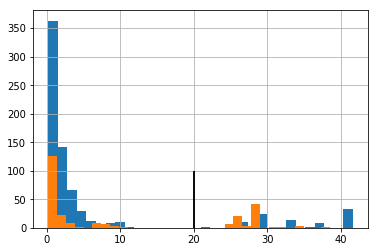

In [8]:
SRC = 'mygene'
df = pd.concat([
    meta.mygene_query('interleukin'),
    meta.mygene_query('chemokine')
])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 0 to 76
Data columns (total 7 columns):
extid           172 non-null object
alias           164 non-null object
ensembl         10 non-null object
ensembl.gene    157 non-null object
name            172 non-null object
symbol          172 non-null object
taxid           172 non-null int64
dtypes: int64(1), object(6)
memory usage: 10.8+ KB


In [10]:
df = df[(~df['name'].str.contains('receptor'))]
df = df[df['name'].str.contains('interleukin') | df['name'].str.contains('chemokine')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 76
Data columns (total 7 columns):
extid           102 non-null object
alias           98 non-null object
ensembl         10 non-null object
ensembl.gene    87 non-null object
name            102 non-null object
symbol          102 non-null object
taxid           102 non-null int64
dtypes: int64(1), object(6)
memory usage: 6.4+ KB


In [11]:
def label_fn(v):
    # Prefer hyphonated labels (e.g. IL-2) for compatibility with other sources
    if not v.startswith('IL'):
        return v
    if 'IL-' in v:
        return v
    return 'IL-' + v[2:]
df = meta.mygene_prep(df, label_fn=label_fn)
df = df.assign(spid=SPECIES_HUMAN_ID, src=SRC)
df = df.drop_duplicates(subset=['sym', 'lbl'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 748 entries, 0 to 776
Data columns (total 5 columns):
sym      748 non-null object
lbl      748 non-null object
extid    748 non-null object
spid     748 non-null int64
src      748 non-null object
dtypes: int64(1), object(4)
memory usage: 35.1+ KB
None


,sym,lbl,extid,spid,src
0,IL-17D,IL-17D,53342,1,mygene
1,interleukin 17D,IL-17D,53342,1,mygene
2,IL17D,IL-17D,53342,1,mygene
4,IL-7,IL-7,3574,1,mygene
5,interleukin 7,IL-7,3574,1,mygene


In [12]:
# Check for (and remove) any excessively vague symbols
df['sym'].unique()

array(['IL-17D', 'interleukin 17D', 'IL17D', 'IL-7', 'interleukin 7',
       'IL7', 'IL-18', 'interleukin 18', 'IL18', 'IGIF', 'IL-1g', 'IL1F4',
       'IL-17C', 'interleukin 17C', 'IL17C', 'CX2', 'IL-17B',
       'interleukin 17B', 'IL17B', 'IL-20', 'NIRF', 'ZCYTO7', 'IL-17F',
       'interleukin 17F', 'IL17F', 'CANDF6', 'ML-1', 'ML1', 'IL-9',
       'interleukin 9', 'IL9', 'HP40', 'P40', 'IL-34', 'interleukin 34',
       'IL34', 'C16orf77', 'IL-15', 'interleukin 15', 'IL15', 'IL-24',
       'interleukin 24', 'IL24', 'C49A', 'FISP', 'IL10B', 'MDA7', 'MOB5',
       'ST16', 'IL-2', 'interleukin 2', 'IL2', 'TCGF', 'lymphokine',
       'IL-12A', 'interleukin 12A', 'IL12A', 'CLMF', 'NFSK', 'NKSF1',
       'P35', 'IL-31', 'interleukin 31', 'IL31', 'IL-22',
       'interleukin 22', 'IL22', 'IL-21', 'IL-D110', 'IL-TIF', 'ILTIF',
       'TIFIL-23', 'TIFa', 'zcyto18', 'IL-32', 'interleukin 32', 'IL32',
       'IL-32alpha', 'IL-32beta', 'IL-32delta', 'IL-32gamma', 'NK4',
       'TAIF', 'TAIFa', 

In [13]:
df[df['sym'].str.match('lymphokine')]

,sym,lbl,extid,spid,src
63,lymphokine,IL-2,3558,1,mygene


In [14]:
dfs = df[~df['sym'].str.match('lymphokine')]
len(dfs), len(df)

(747, 748)

In [15]:
df_mygene = dfs.copy()

In [16]:
df_mygene[df_mygene['lbl'] == 'IL-2']

,sym,lbl,extid,spid,src
58,IL-2,IL-2,3558,1,mygene
59,interleukin 2,IL-2,3558,1,mygene
60,IL2,IL-2,3558,1,mygene
62,TCGF,IL-2,3558,1,mygene


### Load from CytokineRegistry

In [17]:
# Download from https://www.immport.org/docs/CytokineRegistry.November_2015.xls
# to t-cell-relation-extraction/data/meta/raw/cytokines.ckr.xls
SRC = 'ckr'
df = pd.read_excel(osp.join(REPO_DATA_DIR, 'meta', 'raw', 'cytokines.ckr.xls'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 30 columns):
UNIQUE ID                                    275 non-null object
REFERENCE NAME                               275 non-null object
HGNC ID                                      250 non-null object
EntrezGene official name (Human)             255 non-null object
EntrezGeneID (Human)                         255 non-null float64
EntrezGene Symbol (Human)                    255 non-null object
EntrezGene Aliases (Human)                   252 non-null object
EntrezGene Additional Names (Human)          242 non-null object
MGI ID                                       231 non-null object
EntrezGeneofficial name (Mouse)              230 non-null object
EntrezGeneID (Mouse)                         231 non-null float64
EntrezGene Symbol (Mouse)                    231 non-null object
EntrezGene Aliases (Mouse)                   221 non-null object
EntrezGene Additional Names (Mouse)          224

In [18]:
sym_cols = [
    'EntrezGene Aliases (Human)',
    'EntrezGene Symbol (Human)',
    'UniProt protein name (Human)',
    'UniProt protein alternative names (Human)',
    'MeSH Name',
    'Typographical variations',
    'IX Synonyms',
    'Protein Ontology name',
    'Protein Ontology synonyms'
]

def relabel(t):
    
    # Translate greeks
    # - platelet-derived growth factor alpha -> platelet-derived growth factorα)
    # - interferon-alpha 10 -> interferon-α
    for r in greeks.itertuples():
        if ' ' + r.name in t:
            t = t.replace(' ' + r.name, r.letter)
        if '-' + r.name in t:
            t = t.replace(r.name, r.letter)
    
    # These rows have no information beyond reference name so ignore them
    if t == 'Suppressor Factors, Immunologic':
        return None
    if t == 'Macrophage Migration-Inhibitory Factors':
        return None
    
    # Replace patterns in names affecting multiple rows
    if 'Transforming Growth Factor' in t:
        t = t.replace('Transforming Growth Factor', 'TGF')
    elif 'Chemokine ' in t:
        t = t.replace('Chemokine ', '')
    elif 'Interleukin-' in t:
        t = t.replace('Interleukin-', 'IL-')
    elif 'interleukin-' in t:
        t = t.replace('interleukin-', 'IL-')
    elif 'Interferon-' in t:
        t = t.replace('Interferon-', 'IFN-')
    elif 'interferon-' in t:
        t = t.replace('interferon-', 'IFN-')
    elif 'Lymphotoxin-' in t:
        t = t.replace('Lymphotoxin-', 'LT-')
    elif 'Tumor necrosis factor ligand superfamily member ' in t:
        t = t.replace('Tumor necrosis factor ligand superfamily member ', 'TNFSF')
    elif 'platelet-derived growth factor' in t:
        t = t.replace('platelet-derived growth factor', 'PDGF')
    elif 'CKLF-like MARVEL transmembrane domain containing ' in t:
        t = t.replace('CKLF-like MARVEL transmembrane domain containing ', 'CKLFH')
    elif 'Fibroblast Growth Factor-' in t:
        t = t.replace('Fibroblast Growth Factor-', 'FGF')
    
    # Handle single cases
    m = {
        'B-Cell Activating Factor': 'BAFF',
        'B-Cell Stimulating Factor 3': 'BSF-3',
        'CD40 ligand': 'CD40LG',
        'CD70 molecule': 'CD70',
        'Chemokine-like Factor': 'CKLF',
        'Epidermal growth factor': 'EGF',
        'Erythropoietin': 'EPO',
        'Granulocyte Colony-Stimulating Factor': 'G-CSF',
        'Granulocyte-Macrophage Colony-Stimulating Factor': 'GM-CSF',
        'Growth Differentiation Factor 15': 'GDF15',
        'Hepatocyte Growth Factor': 'HGF',
        'IL-12 Subunit p35': 'IL-12A',
        'IL-12 Subunit p40': 'IL-12B',
        'IL-23 Subunit p19': 'IL-23A', 
        'IL-23 Subunit p40': 'IL-23p40',
        'Interferon Type I': 'IFN-1',
        'Interleukin 1 Receptor Antagonist Protein': 'IL-1RA',
        'Leukemia Inhibitory Factor': 'LIF', 
        'Leukocyte Cell Derived Chemotaxin 1': 'LECT1',
        'Leukocyte Cell Derived Chemotaxin 2': 'LECT2',
        'Leukocyte Migration-Inhibitory Factors': 'LMIF',
        'Macrophage Colony-Stimulating Factor 1': 'CSF1',
        'Macrophage Inflammatory Proteins': 'MIP',
        'Macrophage stimulating factor': 'MST1',
        'Macrophage Migration-Inhibitory Factor': 'MIF',
        'Macrophage-Activating Factors': 'MAF',
        'Monocyte Chemoattractant Proteins': 'MCP',
        'Oncostatin M': 'OSM',
        'Osteopontin': 'SPP1',
        'Platelet-Derived Growth Factor': 'PGDF',
        'Resistin': 'RETN',
        'Stem Cell Factor': 'SCF',
        'Thrombopoietin': 'THPO',
        'Transfer Factor': 'TF',
        'Tumor Necrosis Factor-α': 'TNF-α',
        'Tumor Necrosis Factors': 'TNF',
        'XCL-1': 'XCL1',
        'XCL-2': 'XCL2',
        'platelet factor 4 variant 1': 'CXCL4L1'
    }
    if t in m:
        return m[t]
    
    # 
    if t.startswith('IFN'):
        return t.replace(' ', '')
    
    return t

def pivot_df(df):
    res = []
    for i, r in df.iterrows():
        rec = {}
        rec['extid'] = r['UNIQUE ID']
        rec['lbl'] = relabel(r['REFERENCE NAME'])
        
        # Add record where lbl == sym
        row = dict(rec)
        row['sym'] = rec['lbl']
        res.append(row)
        
        # Add individual aliases
        for c in sym_cols:
            for v in (r[c].split(';') if not pd.isnull(r[c]) else []):
                row = dict(rec)
                row['sym'] = v
                res.append(row)
    return pd.DataFrame(res).assign(spid=SPECIES_HUMAN_ID, src=SRC)
       
# As reference name is ultimately used for the "lbl" field, it must be unique
# to ensure that grouping pivoted rows (per-"sym") can be regrouped to original row
assert df['REFERENCE NAME'].value_counts().max()
dfp = pivot_df(df)
dfp = dfp[dfp['lbl'].notnull()]
dfp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8502 entries, 0 to 8509
Data columns (total 5 columns):
extid    8502 non-null object
lbl      8502 non-null object
sym      8502 non-null object
spid     8502 non-null int64
src      8502 non-null object
dtypes: int64(1), object(4)
memory usage: 398.5+ KB


In [19]:
np.sort(dfp['lbl'].unique())

array(['Apo3', 'BAFF', 'BCMA', 'BSF-3', 'CCL1', 'CCL11', 'CCL12', 'CCL13',
       'CCL14', 'CCL15', 'CCL16', 'CCL17', 'CCL18', 'CCL19', 'CCL2',
       'CCL20', 'CCL21', 'CCL22', 'CCL23', 'CCL24', 'CCL25', 'CCL26',
       'CCL27', 'CCL3', 'CCL3L1', 'CCL3L2', 'CCL3L3', 'CCL4', 'CCL4L1',
       'CCL4L2', 'CCL5', 'CCL6', 'CCL7', 'CCL8', 'CCL9', 'CCR1', 'CCR10',
       'CCR2', 'CCR3', 'CCR4', 'CCR5', 'CCR6', 'CCR7', 'CCR8', 'CCR9',
       'CD114', 'CD115', 'CD116', 'CD117', 'CD118', 'CD120a', 'CD120b',
       'CD121a', 'CD122', 'CD123', 'CD124', 'CD126', 'CD127', 'CD130',
       'CD131', 'CD132', 'CD212', 'CD213a1', 'CD213a2', 'CD25', 'CD27',
       'CD30', 'CD4', 'CD40', 'CD40LG', 'CD70', 'CDw119', 'CDw121b',
       'CDw125', 'CDw136', 'CDw137', 'CDw217', 'CKLF', 'CKLFH1', 'CKLFH6',
       'CKLFH7', 'CNTFR', 'CSF1', 'CX3CL1', 'CX3CR1', 'CXCL1', 'CXCL10',
       'CXCL11', 'CXCL12', 'CXCL13', 'CXCL14', 'CXCL15', 'CXCL16',
       'CXCL17', 'CXCL2', 'CXCL3', 'CXCL4', 'CXCL4L1', 'CXCL5', 'CXCL6

In [20]:
dfp.head()

,extid,lbl,sym,spid,src
0,CID_1,BAFF,BAFF,1,ckr
1,CID_1,BAFF,DTL,1,ckr
2,CID_1,BAFF,BAFF,1,ckr
3,CID_1,BAFF,BLYS,1,ckr
4,CID_1,BAFF,CD257,1,ckr


In [21]:
df_ckr = dfp.copy()

### Load from Manual Entries

In [22]:
SRC = 'manual'
df = pd.read_csv(osp.join(META_DATA_DIR, 'raw', 'cytokines.manual.csv'), sep=',')
df = df.assign(src=SRC, extid=None)
df.head()

,sym,lbl,spid,src,extid
0,IL-23,IL-23,1,manual,None
1,IL23,IL-23,1,manual,None
2,IL-35,IL-35,1,manual,None
3,IL35,IL-35,1,manual,None
4,IL-32,IL-32,1,manual,None


In [23]:
df_manual = df.copy()

### Generate Programmatic Transformations

In [24]:
# Function to add greek symbol variations
def expand_greeks(sym):
    syms = [sym]
    for r in greeks.itertuples():
        if r.letter in sym:
            syms.append(sym.replace(r.letter, r.name)) # IFN-γ -> IFN-gamma
            syms.append(sym.replace(r.letter, r.trans)) # IFN-γ -> IFN-g
            break
        if r.name in sym:
            syms.append(sym.replace(r.name, r.letter)) # IFN-gamma -> IFN-γ
            syms.append(sym.replace(r.name, r.trans)) # IFN-gamma -> IFN-g
            break
    return syms

In [25]:
SRC = 'transform'

# Add symbols to resolve references like "interleukin (IL)-4" or "interferon (IFN)-γ"
# as well as ensure that every IL-\d or IL\d+ is present

df = pd.concat([df_cameron, df_mygene, df_ckr, df_manual], sort=True).drop_duplicates()
dfr = []
for prefix, name in [
    ('IL', 'interleukin'), 
    ('IFN', 'interferon'),
    ('TNF', 'tumor necrosis factor'),
    ('TGF', 'transforming growth factor'),
    ('LT', 'lymphotoxin')
]:
    dfp = df[df['sym'].str.startswith(prefix)]
    # Get unique IL numbers, IFN types (alpha, beta, gamma), etc.
    suffixes = dfp['lbl'].str.replace(prefix + '[-]?', '').unique()
    for suffix in suffixes:
        lbl = prefix + '-' + suffix
        syms = [
            prefix + '-' + suffix, # IL-2
            prefix + suffix, # IL2
            '('+ prefix + ')' + suffix, # (IL)2
            '('+ prefix + ') ' + suffix, # (IL) 2
            '('+ prefix + ')-' + suffix, # (IL)-2
            name + ' ' + suffix, # interleukin 2
            name + '-' + suffix, # interleukin-2
            name + ' (' + prefix + ')-' + suffix, # interleukin (IL)-2
        ]
        # Add variations for greek letters
        syms = [v for sym in syms for v in expand_greeks(sym)]
        for sym in syms:
            dfr.append((sym, lbl))
df = pd.DataFrame(dfr, columns=['sym', 'lbl'])
df = df.assign(src=SRC, extid=None, spid=SPECIES_HUMAN_ID)
df_transform = df.copy()
df_transform.head()

,sym,lbl,src,extid,spid
0,IL-1α,IL-1α,transform,None,1
1,IL-1alpha,IL-1α,transform,None,1
2,IL-1a,IL-1α,transform,None,1
3,IL1α,IL-1α,transform,None,1
4,IL1alpha,IL-1α,transform,None,1


### Merge

In [26]:
SRC_PRIORITY = {
    'ckr': 50, 
    'mygene': 40,
    'cameron': 30,
    'manual': 20, 
    'transform': 10
}

In [27]:
df = meta.merge([df_cameron, df_mygene, df_ckr, df_manual, df_transform], ID_TYP_CK).drop_duplicates()
df = meta.add_source_priority(df, SRC_PRIORITY)
df = meta.add_preferred_ids(df)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8914 entries, 7393 to 64
Data columns (total 9 columns):
id          8914 non-null object
src         8914 non-null object
sym         8914 non-null object
lbl         8914 non-null object
spid        8914 non-null int64
extid       6424 non-null object
priority    8914 non-null int64
prefid      8914 non-null object
enabled     8914 non-null bool
dtypes: bool(1), int64(2), object(6)
memory usage: 635.5+ KB
None


,id,src,sym,lbl,spid,extid,priority,prefid,enabled
7393,CK3611DF677712E3BA,ckr,,IFN-α13,1,CID_70,50,CKFF4CE5FD055AC464,True
7162,CKF13169B47CA02EBF,ckr,,GM-CSF,1,CID_63,50,CKFF4CE5FD055AC464,False
5446,CK4FDF8912450D9D7D,ckr,,IL10RB,1,CID_265,50,CKFF4CE5FD055AC464,False
1680,CK4E42BDF10A0E3254,ckr,,MCP,1,CID_146,50,CKFF4CE5FD055AC464,False
2999,CK3C2C332C9A1D0B66,ckr,,CCR6,1,CID_189,50,CKFF4CE5FD055AC464,False


### Filter

In [28]:
# Remove symbols too short to be unambiguous
rm_sym = df[df['sym'].str.len() < MIN_CK_SYM_LEN]['sym'].unique()
print('Removing {} records with excessively short symbols: {}'.format(len(rm_sym), rm_sym))
df = df[~df['sym'].isin(rm_sym)]
df.info()

Removing 15 records with excessively short symbols: ['' 'C7' 'EP' 'FL' 'Je' 'LT' 'MK' 'ML' 'Op' 'SF' 'Sl' 'TF' 'c7' 'lt' 'sf']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8624 entries, 7090 to 64
Data columns (total 9 columns):
id          8624 non-null object
src         8624 non-null object
sym         8624 non-null object
lbl         8624 non-null object
spid        8624 non-null int64
extid       6134 non-null object
priority    8624 non-null int64
prefid      8624 non-null object
enabled     8624 non-null bool
dtypes: bool(1), int64(2), object(6)
memory usage: 614.8+ KB


In [29]:
# Remove shorter symbols that are still ambiguous
def allow_sym(sym):
    # Allow anything greater than 3 chars
    if len(sym) > 3:
        return True
    # Allow il2, il3, etc.
    if re.match('il\d{1}', sym):
        return True
    # Allow p40, p33, p60, etc.
    if re.match('p\d{2}', sym):
        return True
    # Allow anything that is not all lower case and digits: e.g. "ifi", "dif", "esp", "tc1", "tc2", "tr2", etc.
    return not all([c in string.ascii_lowercase or c in string.digits for c in sym])

rm_sym = df[~df['sym'].apply(allow_sym)]['sym'].unique()
print('Removing {} records with short lower case symbols: {}'.format(len(rm_sym), rm_sym))
df = df[~df['sym'].isin(rm_sym)]
df.info()

Removing 67 records with short lower case symbols: ['aif' 'cdf' 'clc' 'cmk' 'cpa' 'cr2' 'cr3' 'dif' 'dmc' 'edf' 'ef7' 'esp'
 'fkn' 'fsf' 'fsp' 'gcf' 'gcp' 'hgf' 'hgi' 'hp1' 'hsf' 'ifb' 'iff' 'ifg'
 'ifi' 'igm' 'ip9' 'khf' 'lai' 'lcf' 'lec' 'lix' 'lmc' 'lmf' 'lpf' 'lta'
 'ltg' 'ltn' 'mea' 'mff' 'mig' 'ml1' 'moc' 'naf' 'ncf' 'ncp' 'nk4' 'nr6'
 'ntn' 'ntt' 'odf' 'pbp' 'pf4' 'plf' 't14' 'taf' 'tc1' 'tc2' 'tcf' 'tgb'
 'tgf' 'tl1' 'tmf' 'tpo' 'tr2' 'trf' 'uii']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8554 entries, 7090 to 64
Data columns (total 9 columns):
id          8554 non-null object
src         8554 non-null object
sym         8554 non-null object
lbl         8554 non-null object
spid        8554 non-null int64
extid       6064 non-null object
priority    8554 non-null int64
prefid      8554 non-null object
enabled     8554 non-null bool
dtypes: bool(1), int64(2), object(6)
memory usage: 609.8+ KB


In [30]:
# Apply static blacklist
df = meta.apply_symbol_filters(df, lib.get_entity_meta_filters(CYTOKINES))
df.info()

Removing 11 symbols in pre-defined filters: ['CD25' 'CD4' 'CD4 molecule' 'CD4mut' 'KIT' 'LIGHT' 'RANK'
 'T-cell differentiation antigen L3T4' 'T-cell surface antigen T4/Leu-3'
 'T-cell surface glycoprotein CD4' 'light']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8542 entries, 7090 to 64
Data columns (total 9 columns):
id          8542 non-null object
src         8542 non-null object
sym         8542 non-null object
lbl         8542 non-null object
spid        8542 non-null int64
extid       6053 non-null object
priority    8542 non-null int64
prefid      8542 non-null object
enabled     8542 non-null bool
dtypes: bool(1), int64(2), object(6)
memory usage: 609.0+ KB


In [31]:
df[df['lbl'].str.lower().str.match('^cd[483]$') | df['sym'].str.lower().str.match('^cd[483]$')]

,id,src,sym,lbl,spid,extid,priority,prefid,enabled


### Summarize

In [32]:
df.groupby(['src', 'enabled']).size().unstack().fillna(0)

enabled,False,True
src,,
cameron,83,27
ckr,96,5211
manual,94,29
mygene,568,178
transform,347,1909


In [33]:
np.sort(df['lbl'].unique())

array(['4-1BB', '4-1BBL', 'APRIL', 'Apo3', 'BAFF', 'BCMA', 'BSF-3',
       'CCL1', 'CCL11', 'CCL12', 'CCL13', 'CCL14', 'CCL15', 'CCL16',
       'CCL17', 'CCL18', 'CCL19', 'CCL2', 'CCL20', 'CCL21', 'CCL22',
       'CCL23', 'CCL24', 'CCL25', 'CCL26', 'CCL27', 'CCL28', 'CCL3',
       'CCL3L1', 'CCL3L2', 'CCL3L3', 'CCL4', 'CCL4L1', 'CCL4L2', 'CCL5',
       'CCL6', 'CCL7', 'CCL8', 'CCL9', 'CCR1', 'CCR10', 'CCR2', 'CCR3',
       'CCR4', 'CCR5', 'CCR6', 'CCR7', 'CCR8', 'CCR9', 'CD114', 'CD115',
       'CD116', 'CD117', 'CD118', 'CD120a', 'CD120b', 'CD121a', 'CD122',
       'CD123', 'CD124', 'CD126', 'CD127', 'CD130', 'CD131', 'CD132',
       'CD153', 'CD154', 'CD178', 'CD212', 'CD213a1', 'CD213a2', 'CD25',
       'CD258', 'CD27', 'CD30', 'CD40', 'CD40LG', 'CD70', 'CDw119',
       'CDw121b', 'CDw125', 'CDw136', 'CDw137', 'CDw217', 'CKLF',
       'CKLFH1', 'CKLFH6', 'CKLFH7', 'CNTFR', 'CSF1', 'CSF2', 'CSF3',
       'CX3CL1', 'CX3CR1', 'CXCL1', 'CXCL10', 'CXCL11', 'CXCL12',
       'CXCL13', 'CXC

In [34]:
df['src'].value_counts()

ckr          5307
transform    2256
mygene        746
manual        123
cameron       110
Name: src, dtype: int64

In [35]:
df[df['lbl'] == 'IFN-γ'].sort_values(['enabled', 'priority'])

,id,src,sym,lbl,spid,extid,priority,prefid,enabled
1042,CKAB0A4DC198C5F1ED,transform,IFN-g,IFN-γ,1,None,10,CKEF3883BE9F74024F,False
1041,CKB14BD5778A003DBA,transform,IFN-gamma,IFN-γ,1,None,10,CKEF3883BE9F74024F,False
1040,CK1B71668FDDECE3CF,transform,IFN-γ,IFN-γ,1,None,10,CKEF3883BE9F74024F,False
1043,CKF88B95F709297E33,transform,IFNγ,IFN-γ,1,None,10,CKEF3883BE9F74024F,False
1056,CK47D24BFC95CEBC4D,transform,interferon gamma,IFN-γ,1,None,10,CKEF3883BE9F74024F,False
1059,CK8E78E2514321441A,transform,interferon-gamma,IFN-γ,1,None,10,CKEF3883BE9F74024F,False
26,CK128EC732B281BF60,cameron,IFN-γ,IFN-γ,1,None,30,CKEF3883BE9F74024F,False
1051,CK27080E286065B3C6,transform,(IFN) g,IFN-γ,1,None,10,CKEF3883BE9F74024F,True
1050,CKE0B9163A8DAECB0E,transform,(IFN) gamma,IFN-γ,1,None,10,CKEF3883BE9F74024F,True
1049,CK8FAB99D623C11005,transform,(IFN) γ,IFN-γ,1,None,10,CKEF3883BE9F74024F,True


### Export

In [36]:
assert df['id'].value_counts().max() == 1

In [37]:
path = osp.join(META_DATA_DIR, CYTOKINES + '.csv')
df.to_csv(path, index=False)
path

'/lab/repos/t-cell-relation-extraction/data/meta/cytokines.csv'